# I. Relevant Imports & loading

In [88]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


loading clean data and extracting an array for modelling purposes

In [15]:
df = pd.read_csv('clean_data.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [19]:
complete1 = df.iloc[:,1:28]

# II. Scaling data for modelling

We use StandardScaler as our method computing the z-score for each observation.

In [22]:
sc = StandardScaler()
complete1_scaled = sc.fit_transform(complete1)

# III. Principal Component Analysis (PCA)

We test PCA here prior to clustering to see if we can simplify the dimensionality in the dataset

In [24]:
pca_alt = PCA(n_components = None)
pca_complete1_scaled = pca_alt.fit_transform(complete1_scaled)

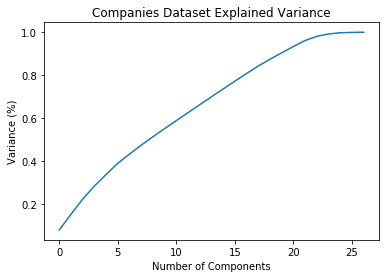

In [28]:
plt.figure()
plt.plot(np.cumsum(pca_alt.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Companies Dataset Explained Variance')
plt.show()

In [29]:
pca_alt = PCA(n_components = 23)
alt30 = pca_alt.fit_transform(complete1_scaled)
print('23 principal components explain:', pca_alt.explained_variance_ratio_.sum(), 'of the data variance')

23 principal components explain: 0.9811376200367439 of the data variance


In [30]:
alt_df = pd.DataFrame(alt30, columns=[f'PC{x+1}' for x in range((pca_alt.n_components_))])

alt_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-1.005843,0.481199,5.101498,0.089538,-13.541418,-3.067082,3.307921,1.146352,-0.300967,0.139215,...,0.507754,0.578179,-0.212332,-0.044184,-0.878173,-0.592459,0.472801,-0.451458,-1.283281,-15.045729
1,-1.813818,1.306174,8.650017,0.142135,-25.587431,-5.869535,6.377882,1.870509,-0.790759,0.327951,...,0.908642,0.896433,-0.486427,0.279714,0.197316,-0.122635,0.341679,-0.951630,-1.082172,-9.552885
2,-0.565998,-0.025622,2.535041,-0.038812,-5.949170,-3.096502,0.217566,0.827674,0.050900,0.292614,...,0.453284,0.137622,-0.322196,0.290186,0.485188,-1.103649,0.095274,0.812278,0.840421,-7.805763
3,-0.720647,0.419112,3.023505,0.033532,-9.481429,-3.364922,0.556363,1.144766,1.531217,0.113747,...,0.968637,0.210578,-0.444655,-0.531481,0.151787,-1.160301,0.034264,1.171804,1.563625,0.609390
4,-0.317726,0.783534,0.392928,0.007687,-1.268800,-0.397266,-0.039241,-0.026658,0.076277,-0.072112,...,-0.029409,-0.151209,-0.096920,0.106117,0.390310,-0.197276,0.141744,-0.043493,0.378935,0.372608


Evaluating effect of PCA:

- We could reduce the dataset to 23 principal components as opposed to 27 and preserve most of the variance of the data. 
- We will run clustering on PCA data but considering the limited effect of PCA on this data we will focus on non-PCA data.

# IV. KMeans Clustering - PCA Data

- We use the 'Elbow' method to look for the optimal number of clusters. 
- We don't treat the elbow method as absolute truth but use it as an indicator of where our model potentially fits best.
- We use two variants of the elbow method: Distortion (sum of squared distances from centroid) / clainski_harabasz (ratio of dispersion between / within clusters)
- The elbow method works well for closely clustered data.

In [50]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(4,80))

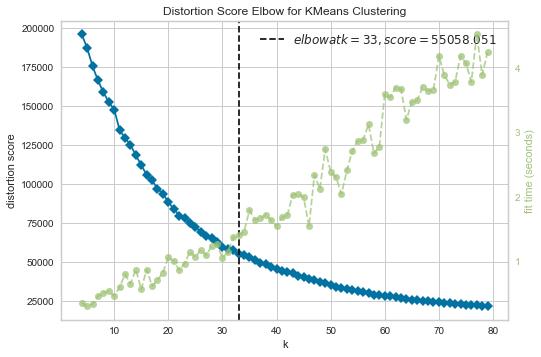

In [51]:
visualizer.fit(alt_df)
visualizer.poof().get_figure()

In [61]:
visualizer1 = KElbowVisualizer(km, k=(4,80), metric ='calinski_harabasz', locate_elbow = True)
visualizer1.fit(alt_df)

Limited results with this second method

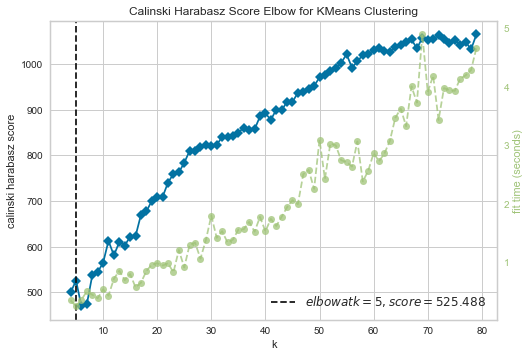

In [63]:
visualizer1.poof().get_figure()

In [68]:
number_clusters = 33
pca_km_alt = KMeans(n_clusters = number_clusters, n_init = 10, random_state =0)
pca_km_alt.fit(alt_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=33, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [69]:
predicted_alt_pca = pca_km_alt.predict(alt_df)

In [70]:
predicted_alt_pca

array([ 3,  3, 24, ..., 17, 17, 17], dtype=int32)

No cluster separation visible within the elected principal components below

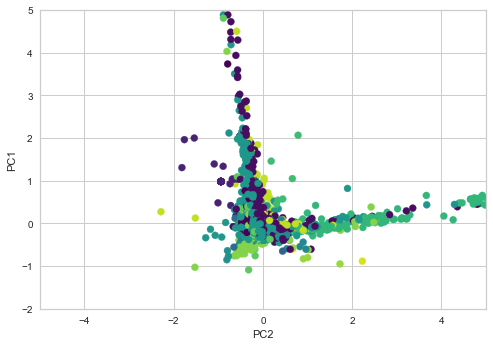

In [86]:
plt.axis([-5,5,-2,5])
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.scatter(alt30[:,0], alt30[:,1], c = predicted_alt_pca, cmap = 'viridis')

From the below we notice clusters that deal with bunched data combined with outliers
 - multidimensional scaling used

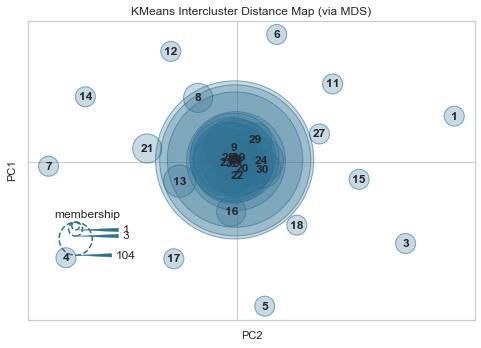

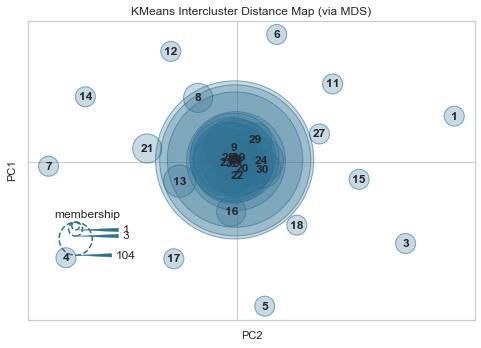

In [85]:
model = KMeans(33)
int_clust_dist = InterclusterDistance(model)
int_clust_dist.fit(alt_df)
int_clust_dist.poof().get_figure()

Adding another dimension to understand data dispersion

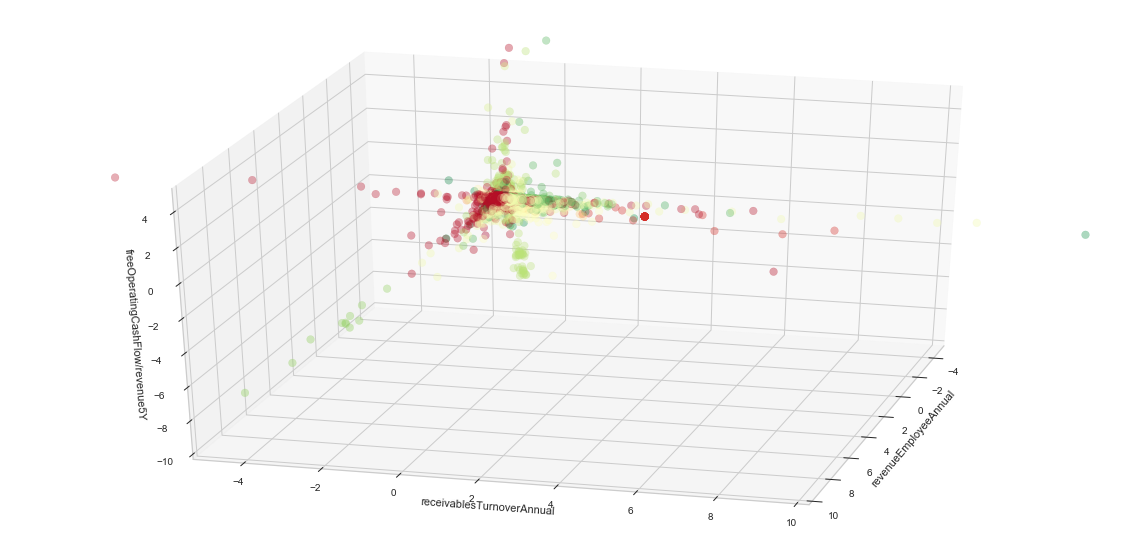

In [92]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('revenueEmployeeAnnual') #check PCA extraction
ax.set_ylabel('receivablesTurnoverAnnual') #check PCA extraction
ax.set_zlabel('freeOperatingCashFlow/revenue5Y') #check PCA extraction
ax.scatter(alt30[:,1], alt30[:,2], alt30[:,3], c=predicted_alt_pca , s=60,cmap="RdYlGn")
ax.set_xlim3d(-5, 10)
ax.set_ylim3d(-5,10)
ax.set_zlim3d(-10,5)
ax.view_init(30, 15)
plt.show()